# Training your MLP

In [1]:
%reset -f
import ipdb

import logging
import sys

my_stderr = sys.stderr = open('errors.txt', 'w')  # redirect stderr to file
get_ipython().log.handlers[0].stream = my_stderr  # log errors to new stderr
get_ipython().log.setLevel(logging.INFO)  # errors are logged at info level
LASER="LASER-master" # location of laser
mldir = "ml-training/SECRECY-EN/data_random_negatives_full_test" # training data and embeddings are held here
model_name = "SECRECY-EN"
edir = mldir + "/embed" # location of laser script that that embeds to LASER SS
languages = ['en','es'] # languages that are of interest for testing
languages_str = ' '.join(languages)
#embedding_name = 'LASER_USEm'
embedding_name = 'USEm'

In [2]:
# %matplotlib inline
import os
import math
import argparse
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import mplcursors
import pickle
import ast
from scipy.special import softmax

import ipdb

################################################

def LoadData(bdir, dfn, lfn, dim="{}", bsize=32, shuffle=False, quiet=False):
    
    embed_types = dfn.split('.')[1].split('_')
    split = dfn.split('.')[0]
    lang = dfn.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_list = []
    for embdtyp in embed_types:
        dfn = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x = np.fromfile(bdir + dfn, dtype=np.float32, count=-1)
        x.resize(x.shape[0] // dim[embdtyp], dim[embdtyp])
        x_list.append(x)
    
    x = np.hstack(x_list)
    
    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    D = data_utils.TensorDataset(torch.from_numpy(x), torch.from_numpy(lbl))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader


def LoadDataList(bdir, dfn_list, lfn, dim="{}", bsize=32, shuffle=False, quiet=False):
    
    # dfn_list is a list of datasets
    xs = []
    dim = ast.literal_eval(dim)
    for dfn in dfn_list:
        embed_types = dfn.split('.')[1].split('_')
        split = dfn.split('.')[0]
        lang = dfn.split('.')[-1]
        x_list = []
        for embdtyp in embed_types:
            dfn = '{}.{}.enc.{}'.format(split, embdtyp, lang)
            x = np.fromfile(bdir + dfn, dtype=np.float32, count=-1)
            x.resize(x.shape[0] // dim[embdtyp], dim[embdtyp])
            x_list.append(x)
        x = np.hstack(x_list)
        xs.append(x)
    
    x = np.vstack(xs)
    
    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    D = data_utils.TensorDataset(torch.from_numpy(x), torch.from_numpy(lbl))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader



################################################

def LoadData_pos(bdir, dfn, lfn, dim="{}", bsize=1, shuffle=True, quiet=False):
    embed_types = dfn.split('.')[1].split('_')
    split = dfn.split('.')[0]
    lang = dfn.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_list = []
    for embdtyp in embed_types:
        dfn = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x = np.fromfile(bdir + dfn, dtype=np.float32, count=-1)
        x.resize(x.shape[0] // dim[embdtyp], dim[embdtyp])
        x_list.append(x)
    
    x = np.hstack(x_list)

    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    
    x_pos = x[lbl==1]
    lbl_pos = lbl[lbl==1]
    
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    D = data_utils.TensorDataset(torch.from_numpy(x_pos), torch.from_numpy(lbl_pos))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader


################################################

def LoadText(bdir, dfn, lfn, dim="{}", bsize=32, shuffle=False, quiet=False):
    #file_name = (bdir + dfn).replace('laser_usem.enc','txt')
    file_name = (bdir + dfn).replace(embedding_name + '.enc','txt')
    txt = np.loadtxt(file_name,dtype=object, delimiter='\n',comments=None)

    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    if not quiet:
        print(' - read {:d} text elements in {:s}'.format(txt.shape[0], file_name))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    assert txt.shape[0] == lbl.shape[0] , 'Mismatched Dimensions While Loading Text'
    return {'text':txt, 'labels':lbl}


################################################

def LoadTrainDevData(bdir, dfn_train, lfn_train, dfn_dev, lfn_dev ,dim="{}", bsize=32, shuffle=False, quiet=False):

#     x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
#     x_train.resize(x_train.shape[0] // dim, dim)
        
    embed_types = dfn_train.split('.')[1].split('_')
    split = dfn_train.split('.')[0]
    lang = dfn_train.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_train_list = []
    for embdtyp in embed_types:
        dfn_train = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
        x_train.resize(x_train.shape[0] // dim[embdtyp], dim[embdtyp])
        x_train_list.append(x_train)
    
    x_train = np.hstack(x_train_list)    

    lbl_train = np.loadtxt(bdir + lfn_train, dtype=np.int32)
    lbl_train.reshape(lbl_train.shape[0], 1)

    ######
    
#     x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
#     x_dev.resize(x_dev.shape[0] // dim, dim)

    embed_types = dfn_dev.split('.')[1].split('_')
    split = dfn_dev.split('.')[0]
    lang = dfn_dev.split('.')[-1]    
        
    x_dev_list = []
    for embdtyp in embed_types:
        dfn_dev = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
        x_dev.resize(x_dev.shape[0] // dim[embdtyp], dim[embdtyp])
        x_dev_list.append(x_dev)
    
    x_dev = np.hstack(x_dev_list)    
    
    
    lbl_dev = np.loadtxt(bdir + lfn_dev, dtype=np.int32)
    lbl_dev.reshape(lbl_dev.shape[0], 1)
        
    x = np.vstack((x_train,x_dev))
    lbl = np.concatenate((lbl_train,lbl_dev), axis=0)
        
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn_train + dfn_dev))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn_train + lfn_dev))

    D = data_utils.TensorDataset(torch.from_numpy(x), torch.from_numpy(lbl))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader

################################################

def LoadTrainDevData_pos(bdir, dfn_train, lfn_train, dfn_dev, lfn_dev, dim="{}", bsize=1, shuffle=True, quiet=False):
#     x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
#     x_train.resize(x_train.shape[0] // dim, dim)
    
    embed_types = dfn_train.split('.')[1].split('_')
    split = dfn_train.split('.')[0]
    lang = dfn_train.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_train_list = []
    for embdtyp in embed_types:
        dfn_train = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
        x_train.resize(x_train.shape[0] // dim[embdtyp], dim[embdtyp])
        x_train_list.append(x_train)
    
    x_train = np.hstack(x_train_list)    
    lbl_train = np.loadtxt(bdir + lfn_train, dtype=np.int32)
    lbl_train.reshape(lbl_train.shape[0], 1)

    ######
    
#     x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
#     x_dev.resize(x_dev.shape[0] // dim, dim)

    embed_types = dfn_dev.split('.')[1].split('_')
    split = dfn_dev.split('.')[0]
    lang = dfn_dev.split('.')[-1]
        
    x_dev_list = []
    for embdtyp in embed_types:
        dfn_dev = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
        x_dev.resize(x_dev.shape[0] // dim[embdtyp], dim[embdtyp])
        x_dev_list.append(x_dev)
    
    x_dev = np.hstack(x_dev_list)    
    lbl_dev = np.loadtxt(bdir + lfn_dev, dtype=np.int32)
    lbl_dev.reshape(lbl_dev.shape[0], 1)
    
    ######
    
    x = np.vstack((x_train,x_dev))
    lbl = np.concatenate((lbl_train,lbl_dev), axis=0)
        
    x_pos = x[lbl==1]
    lbl_pos = lbl[lbl==1]
    
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x_pos.shape[0], x_pos.shape[1], dfn_train + dfn_dev))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl_pos.shape[0], lbl_pos.min(), lbl_pos.max(), lfn_train + lfn_dev))

    D = data_utils.TensorDataset(torch.from_numpy(x_pos), torch.from_numpy(lbl_pos))    
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader


################################################


class Net(nn.Module):
    def __init__(self, idim="{}", odim=2, nhid=None,
                 dropout=0.0, gpu=0, activation='RELU'):
        super(Net, self).__init__()
        
        idim = ast.literal_eval(idim)
        idim = sum([i for i in list(idim.values())])
        
        self.gpu = gpu
        modules = []

        modules = []
        print(' - mlp {:d}'.format(idim), end='')
        if len(nhid) > 0:
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
            nprev = idim
            for nh in nhid:
                if nh > 0:
                    modules.append(nn.Linear(nprev, nh))
                    nprev = nh
                    if activation == 'TANH':
                        modules.append(nn.Tanh())
                        print('-{:d}t'.format(nh), end='')
                    elif activation == 'RELU':
                        modules.append(nn.ReLU())
                        print('-{:d}r'.format(nh), end='')
                    else:
                       raise Exception('Unrecognized activation {activation}')
                    if dropout > 0:
                        modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(nprev, odim))
            print('-{:d}, dropout={:.1f}'.format(odim, dropout))
        else:
            modules.append(nn.Linear(idim, odim))
            print(' - mlp %d-%d'.format(idim, odim))
        self.mlp = nn.Sequential(*modules)
        # Softmax is included CrossEntropyLoss !

        if self.gpu >= 0:
            self.mlp = self.mlp.cuda()

    def forward(self, x):
        return self.mlp(x)

    def TestCorpus(self, dset, name='', nlbl=2):
        correct = 0
        total = 0
        self.mlp.train(mode=False)
        corr = np.zeros(nlbl, dtype=np.int32)
        for data in dset:
            X, Y = data
            Y = Y.long()
            if self.gpu >= 0:
                X = X.cuda()
                Y = Y.cuda()
            outputs = self.mlp(X)
            _, predicted = torch.max(outputs.data, 1)
            total += Y.size(0)
            correct += (predicted == Y).int().sum()
            for i in range(nlbl):
                corr[i] += (predicted == i).int().sum()

        print(' | {:4s}: {:5.2f}%'
                         .format(name, 100.0 * correct.float() / total), end='')
        print(' | classes:', end='')
        for i in range(nlbl):
            print(' {:5.2f}'.format(100.0 * corr[i] / total), end='')

        return correct, total

    # net_best.TestCorpus_cstm(test_loader, 'Test',nlbl=args.nb_classes, txt=test_txt)
    # have this function output a dataframe with confidence scores!
    def TestCorpus_cstm(self, dset, name='', nlbl=2, txt=None, return_df=False, verbose=False):
        correct = 0
        total = 0
        self.mlp.train(mode=False)
        corr = np.zeros(nlbl, dtype=np.int32)
        
        if args.gpu >= 0:
            criterion = nn.CrossEntropyLoss().cuda()
        else:
            criterion = nn.CrossEntropyLoss()

        Y_all = torch.empty(0, dtype=torch.int64)
        predicted_all = torch.empty(0, dtype=torch.int64)
        loss_all = 0
        probs_all = []
        batches = 0
#         for data in dset:
        for i, data in enumerate(dset, 0):
            X, Y = data
            Y = Y.long()
            Y_all = torch.cat((Y_all,Y))
            if self.gpu >= 0:
                X = X.cuda()
                Y = Y.cuda()
            outputs = self.mlp(X)
            # convert to probabilities:
            scores = outputs.detach().numpy()
            probs = softmax(scores, axis=1)
            probs = [x[1] for x in probs.tolist()]
            probs_all = probs_all + probs
            _, predicted = torch.max(outputs.data, 1) # outputs are the model scores
            if (txt!=None) & (i%100==0):
                if verbose:
                    print('len(data), len(probs), len(predicted)')
                    print(len(data[0]), len(probs), len(predicted.cpu()))
                    print('data:')
                    print(data)
                    print('Probs:')
                    print(probs)
                    print('outputs.data:')
                    print(pd.DataFrame(outputs.data).astype(float))
                    print('predicted:')
                    print(predicted)
                    #return 0
            predicted_all = torch.cat((predicted_all,predicted.cpu()))
            total += Y.size(0)
            correct += (predicted == Y).int().sum()
            for i in range(nlbl):
                corr[i] += (predicted == i).int().sum()
                
            loss_all += criterion(outputs, Y)
            batches += 1
        
        # all predictions
        if (txt!=None) & (return_df):
            #print(predicted_all) # or print dataframe
            # TO DO: add column with model scores instead of class predictions
            #print('len text, labels, predictions, model_scores')
            #print(len(txt['text']), len(txt['labels']), len(predicted_all.tolist()), len(probs_all))
            df = pd.DataFrame({'text': txt['text'], 'labels': txt['labels'], 'predictions': predicted_all.tolist(), 'model_scores': probs_all})
            if verbose:
                print('Test Dataframe:')
                print(df)
        
        avg_loss = loss_all/float(batches)
        print(' | {:4s}: {:5.2f}%'
                         .format(name, 100.0 * correct.float() / total), end='')
        print(' | classes:', end='')
        for i in range(nlbl):
            print(' {:5.2f}'.format(100.0 * corr[i] / total), end='')
        
        clf_report = classification_report(Y_all, predicted_all, output_dict=True)
        print('\n')
        print(classification_report(Y_all, predicted_all))
        
        # Fail State Analysis
        FP = []
        FN = []
        TP = []
        if txt is not None:
            for idx, txt_label in enumerate(txt['labels']):
                assert txt_label == Y_all[idx].item(), 'Mismatched labels'
                
                # TP
                if (Y_all[idx].item() == 1) and (predicted_all[idx].item() == 1):
                    TP.append((idx, txt['text'][idx]))

                # FP
                if (Y_all[idx].item() == 0) and (predicted_all[idx].item() == 1):
                    FP.append((idx, txt['text'][idx]))
                
                # FN
                if (Y_all[idx].item() == 1) and (predicted_all[idx].item() == 0):
                    FN.append((idx, txt['text'][idx]))

            fail_state = {'TP':TP,'FP':FP,'FN':FN}
            clf_report['fail_state'] = fail_state
                    

        if return_df:
            return correct, total, avg_loss, clf_report, df
        else:
            return correct, total, avg_loss, clf_report


################################################

In [3]:
parser = argparse.ArgumentParser(
           formatter_class=argparse.RawDescriptionHelpFormatter,
           description="Simple sentence classifier")

# Data
parser.add_argument('--base-dir', '-b', type=str, required=True, metavar='PATH',help="Directory with all the data files)")
parser.add_argument('--plot-name', '-p', type=str, required=True, metavar='PATH',help="name of plot file")
parser.add_argument('--save', '-s', type=str, required=False, metavar='PATH', default="",help="File in which to save best network")
parser.add_argument('--train', '-t', type=str, required=True, metavar='STR',help="Name of training corpus")
parser.add_argument('--train-labels', '-T', type=str, required=True, metavar='STR',help="Name of training corpus (labels)")
parser.add_argument('--dev', '-d', type=str, required=True, metavar='STR',help="Name of development corpus")
parser.add_argument('--dev-labels', '-D', type=str, required=True, metavar='STR',help="Name of development corpus (labels)")
parser.add_argument('--test', '-e', type=str, required=True, metavar='STR',help="Name of test corpus without language extension")
parser.add_argument('--test-labels', '-E', type=str, required=True, metavar='STR',help="Name of test corpus without language extension (labels)")
parser.add_argument('--lang', '-L', nargs='+', default=None,help="List of languages to test on")

# network definition
parser.add_argument("--dim", "-m", type=str, default="{}",help="Dimension of sentence embeddings")
parser.add_argument('--nhid', '-n', type=int, default=[0], nargs='+',help="List of hidden layer(s) dimensions")
parser.add_argument("--nb-classes", "-c", type=int, default=2,help="Number of output classes")
parser.add_argument('--dropout', '-o', type=float, default=0.0, metavar='FLOAT',help="Value  of dropout")
parser.add_argument('--nepoch', '-N', type=int, default=100, metavar='INT',help="Number of epochs")
parser.add_argument('--bsize', '-B', type=int, default=128, metavar='INT',help="Batch size")
parser.add_argument('--seed', '-S', type=int, default=123456789, metavar='INT',help="Initial random seed")
parser.add_argument('--lr', type=float, default=0.001, metavar='FLOAT',help='Learning rate')
parser.add_argument('--wdecay', type=float, default=0.0, metavar='FLOAT',help='Weight decay')
parser.add_argument('--gpu', '-g', type=int, default=-1, metavar='INT',help="GPU id (-1 for CPU)")

ltrn = 'en' # change for spanish
ldev = ltrn
nb_cl=2
N=100
lr=0.001
wd=0.0

# for laser+usem
#dim = {'usem':512,'laser':1024}

# for usem only
#dim = {'usem':512}
dim = {embedding_name:512}

# nhid=['256','128']
nhid=['768','128']
gpu='-1'

drop=0.5
seed=1
bsize=512
plot_name = model_name + "_lr_wd_" + model_name + ".png"
save_model = model_name + "_best_model_test_" + embedding_name

args_list = ['--gpu', gpu,
            '--base-dir', edir,
            #'--train', "train.{}.enc.".format(embedding_name.lower())+ltrn,
            '--train', "train.{}.enc.".format(embedding_name)+ltrn, 
            '--train-labels', "train.lbl."+ltrn,
            #'--dev', "dev.{}.enc.".format(embedding_name.lower())+ldev,
            '--dev', "dev.{}.enc.".format(embedding_name)+ldev,
            '--dev-labels', "dev.lbl."+ldev,
            #'--test', "test.{}.enc".format(embedding_name.lower()),
            '--test', "test.{}.enc".format(embedding_name),
            '--test-labels', "test.lbl",
            '--dim', str(dim),
            '--nb-classes', str(nb_cl),
            '--nhid', *nhid,
            '--dropout', str(drop),
            '--bsize', str(bsize),
            '--seed', str(seed),
            '--lr', str(lr),
            '--wdecay', str(wd),
            '--nepoch', str(N),
            '--lang', *languages,
            '--save', save_model,
            '--plot-name', plot_name]

args = parser.parse_args(args_list)
print(' - base directory: {}'.format(args.base_dir))
args.base_dir = args.base_dir + "/"


 - base directory: ml-training/SECRECY-EN/data_random_negatives_full_test/embed


In [4]:
args.test_list_en = ['test.USEm.enc.en_' + str(i) for i in range(692)]
print(len(args.test_list_en))
#print(args.test_list_en)

args.test_list_es = ['test.USEm.enc.es_' + str(i) for i in range(82)]
print(len(args.test_list_es))
#print(args.test_list_es)

692
82


 - setting seed to 1
 - read 10544x512 elements in train.USEm.enc.en
 - read 10544 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10544x512 elements in train.USEm.enc.en
 - read 10544 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10544x512 elements in train.USEm.enc.en
 - read 10544 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10544x512 elements in train.USEm.enc.en
 - read 10544 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10544x512 elements in train.USEm.enc.en
 - read 10544 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001


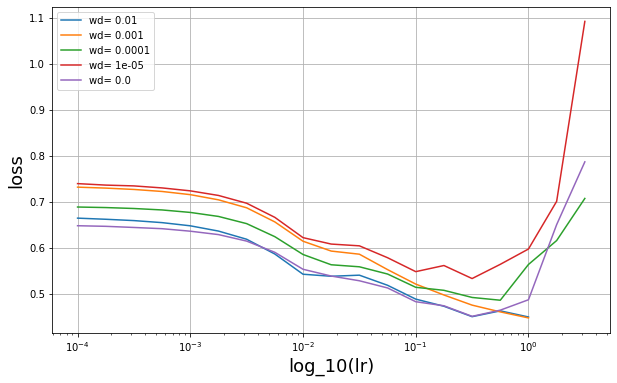

In [5]:
# PURPOSE OF THIS CELL IS TO FIND OPTIMAL VALUE OF LR AND WD
# SEE https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
# note this is done using only the training set, no dev set required

def find_lr_wd(args, init_value = 1e-4, final_value=10., beta = 0.98, wd = [1e-2, 1e-3, 1e-4, 1e-5, 0.0]):
    
    # set GPU and random seed
    torch.cuda.set_device(args.gpu)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    print(" - setting seed to %d" % args.seed)

    wd_lr_loss = {}
    plt.figure(figsize=(10,6))


######################

######################
    


    for wd_i in wd:    
        train_loader = LoadData(args.base_dir, args.train, args.train_labels,
                            dim=args.dim, bsize=args.bsize, shuffle=True)

        # create network
        net = Net(idim=args.dim, odim=args.nb_classes,
                  nhid=args.nhid, dropout=args.dropout, gpu=args.gpu)
        if args.gpu >= 0:
            criterion = nn.CrossEntropyLoss().cuda()
        else:
            criterion = nn.CrossEntropyLoss()

        optimizer = optim.AdamW(net.parameters(),
                               lr=args.lr,
                               weight_decay=wd_i,
                               betas=(0.9, 0.999),
                               eps=1e-8,
                               amsgrad=False)

        num = len(train_loader)-1
        print("num: {}".format(num))
        print("final_value: {}".format(final_value))
        print("init_value: {}".format(init_value))
        mult = (final_value / init_value) ** (1/num)
        lr = init_value

        optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        lrs = []

        for i, data in enumerate(train_loader, 0):
            batch_num += 1
            # get the inputs
            inputs, labels = data
            labels = labels.long()
            if args.gpu >= 0:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            net.zero_grad()

            # forward + backward + optimize
            net.train(mode=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            #Compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.data.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            #Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                wd_lr_loss[wd_i] = {'lrs':lrs, 'losses':losses}
                break

            #Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            #Store the values
            losses.append(smoothed_loss)
            lrs.append(lr)

            #Do the SGD step
            loss.backward()
            optimizer.step()            

            #Update the lr for the next step
            lr *= mult
            optimizer.param_groups[0]['lr'] = lr
            
        wd_lr_loss[wd_i] = {'lrs':lrs, 'losses':losses}

        plt.plot(lrs,losses,label='wd= '+str(wd_i))
    
    plt.legend(loc='best')
    plt.xlabel('log_10(lr)',fontsize=18)
    plt.ylabel('loss',fontsize=18)
    plt.xticks(np.linspace(init_value, final_value,10))
    plt.xscale("log")
    plt.grid()
    plt.savefig(args.plot_name)
            
    return wd_lr_loss

wd_lr_loss = find_lr_wd(args)

In [6]:
# looks like optimal wd is 0.001
# optimal lr (where loss is decreasing the fastest) is around 10^-2 (0.01)
lr_opt = 0.01
wd_opt = 0.0

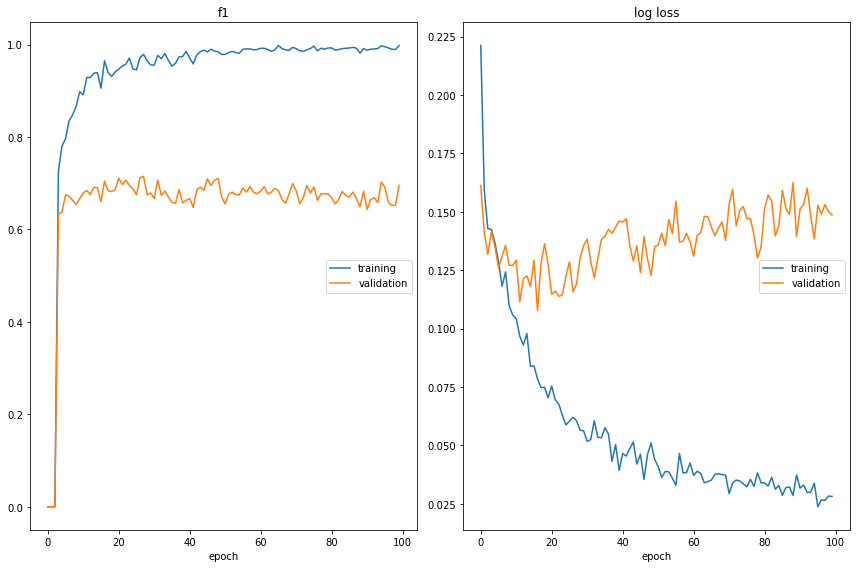

f1
	training         	 (min:    0.000, max:    0.998, cur:    0.998)
	validation       	 (min:    0.000, max:    0.715, cur:    0.695)
log loss
	training         	 (min:    0.024, max:    0.221, cur:    0.028)
	validation       	 (min:    0.108, max:    0.162, cur:    0.149)


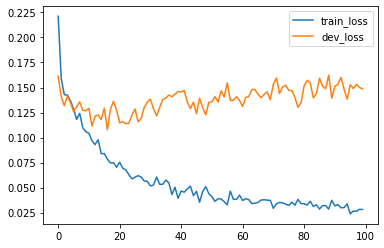

SECRECY-EN_best_model_test_USEm
Best Dev: 27 epochs. Best f1 score is 71.47%
****************
****************
****************
****************
Ep best | Eval Test lang en

 | Test: 99.23% | classes: 99.20  0.80

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    691519
           1       0.06      0.71      0.11       451

    accuracy                           0.99    691970
   macro avg       0.53      0.85      0.55    691970
weighted avg       1.00      0.99      1.00    691970



Ep best | Eval Test lang es

 | Test: 96.62% | classes: 96.60  3.40

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     81607
           1       0.02      0.59      0.04        90

    accuracy                           0.97     81697
   macro avg       0.51      0.78      0.51     81697
weighted avg       1.00      0.97      0.98     81697





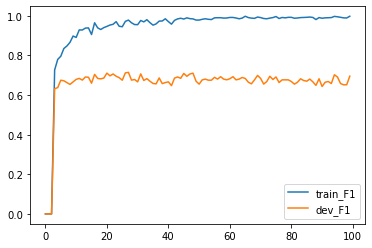

In [7]:
# PURPOSE OF THIS CELL IS TO FIND OPTIMAL BUMBER OF EPOCHS
# at every epoch from 1 to 100, we train a nn on the train set and evaluate on the dev set.
# we save the optimal epoch (in terms of f1), the f1 score, and the trained net
# finally, we predict on the test set (not dev) with net_best. Note that net_best was trained only on train, not train+dev

# optimal hyperparams from the previous cell
#lr_opt = 0.001
#wd_opt = 0.0

args.nepoch = 100
args.training_plot = model_name + "_nepoch_" + model_name + ".png"
args.lr = lr_opt
args.wdecay = wd_opt
# train only training data
def dev_train_mlp(args):
        
    liveloss = PlotLosses()

    train_loader = LoadData(args.base_dir, args.train, args.train_labels,
                            dim=args.dim, bsize=args.bsize, shuffle=True)

    train_pos = LoadData_pos(args.base_dir, args.train, args.train_labels,
                            dim=args.dim, bsize=1, shuffle=True)

    dev_loader = LoadData(args.base_dir, args.dev, args.dev_labels,
                          dim=args.dim, bsize=args.bsize, shuffle=False)

    dev_text = LoadText(args.base_dir, args.dev, args.dev_labels,
                          dim=args.dim, bsize=args.bsize, shuffle=False)

    
    # set GPU and random seed
    torch.cuda.set_device(args.gpu)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    print(" - setting seed to %d" % args.seed)

    # create network
    net = Net(idim=args.dim, odim=args.nb_classes,
              nhid=args.nhid, dropout=args.dropout, gpu=args.gpu)
    if args.gpu >= 0:
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        criterion = nn.CrossEntropyLoss()

    #optimizer = optim.Adam(net.parameters(), weight_decay=0.0)
    # default: pytorch/optim/adam.py
    # Py0.4: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    # Py1.0: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    optimizer = optim.AdamW(net.parameters(),
                           lr=args.lr,
                           weight_decay=args.wdecay,
                           betas=(0.9, 0.999),
                           eps=1e-8,
                           amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                                max_lr=args.lr,
    #                                                steps_per_epoch=len(train_loader),
    #                                                epochs=args.nepoch)
    
    epoch_train_loss = []
    epoch_dev_loss = []
    epoch_train_f1 = []
    epoch_dev_f1 = []
    epoch_id = []
    
    corr_best = 0
    f1_best = 0
    # loop multiple times over the dataset
    for epoch in range(args.nepoch):
        logs = {}

        loss_epoch = 0.0
        print('Ep {:4d}'.format(epoch), end='')
        # for inputs, labels in train_loader:
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            # augment with pos sample
            if data[1][data[1]==1].shape[0] == 0:
                aug_data_pos = iter(train_pos).next()
                inputs = torch.cat([inputs,aug_data_pos[0]])
                labels = torch.cat([labels,aug_data_pos[1]])
            
            labels = labels.long()
            if args.gpu >= 0:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients            
            net.zero_grad()

            # forward + backward + optimize
            net.train(mode=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #for param_group in optimizer.param_groups:
            #    print(param_group['lr'])          
            #scheduler.step()

            loss_epoch += loss.item()
            
            torch.cuda.empty_cache()
            
            
        print(' | loss {:e}'.format(loss_epoch), end='')
        print('\n')
        torch.cuda.empty_cache()
        _, _, _, train_clf_reprt = net.TestCorpus_cstm(train_loader, 'Train',nlbl=args.nb_classes)
        torch.cuda.empty_cache()
        del _
        # return correct, total, avg_loss, clf_report
        corr, nbex, dev_loss, dev_clf_reprt = net.TestCorpus_cstm(dev_loader, 'Dev', nlbl=args.nb_classes, txt=dev_text, verbose=False)
        
        # Epoch metrics (train/dev, loss/F1)
        f1 = dev_clf_reprt['1']['f1-score']
        
        epoch_id.append(epoch)
        
        epoch_train_loss.append(loss_epoch/float(i))
        epoch_dev_loss.append(dev_loss.item())
        
        epoch_train_f1.append(train_clf_reprt['1']['f1-score'])
        epoch_dev_f1.append(dev_clf_reprt['1']['f1-score'])
        
        
        # Keeping Record of Best MLP net (based on Dev set)
        #if corr >= corr_best:
        if f1 >= f1_best:
            print(' | saved')
            f1_best = f1
            epoch_best = epoch
            net_best = copy.deepcopy(net)
        else:
            print('')
                    
        ## Plot epochs metrics 
        logs['' + 'log loss'] = loss_epoch/float(i)
        logs['' + 'f1'] = train_clf_reprt['1']['f1-score']
        logs['val_' + 'log loss'] = dev_loss.item()
        logs['val_' + 'f1'] = dev_clf_reprt['1']['f1-score']
        
        liveloss.update(logs)
        liveloss.draw()
        
        torch.cuda.empty_cache()

    plt.plot(epoch_id, epoch_train_loss, label='train_loss')
    plt.plot(epoch_id, epoch_dev_loss, label='dev_loss')
    plt.legend(loc='best')
    plt.show()

    plt.plot(epoch_id, epoch_train_f1, label='train_F1')
    plt.plot(epoch_id, epoch_dev_f1, label='dev_F1')
    plt.legend(loc='best')
    plt.savefig(args.training_plot)
    

    # Saving best MLP net and Producing Zero-Shot Multilingual Results
    if args.save != '':
        torch.save(net_best.cpu(), args.save+'_dev')
        print(args.save)
    print('Best Dev: {:d} epochs. Best f1 score is {:5.2f}%'.format(epoch_best, 100.0 * f1_best))
    print('****************\n****************\n****************\n****************')

    if args.gpu >= 0:
        net_best = net_best.cuda()

    # test on (several) languages
    test_clf_reprt = {}
    for l in args.lang:
        if l=='en':
            test_list = args.test_list_en
        if l=='es':
            test_list = args.test_list_es
            
        
        test_loader = LoadDataList(args.base_dir, test_list,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        test_txt = LoadText(args.base_dir, args.test + '.' + l,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        print('Ep best | Eval Test lang {:s}'.format(l), end='')
        print('\n')
        _, _, _, test_clf_reprt[l] = net_best.TestCorpus_cstm(test_loader, 'Test',nlbl=args.nb_classes, txt=test_txt)
        print('\n')
    
    pickle.dump(test_clf_reprt, open( save_model+'_test_metrics_w_dev_model.pkl', "wb" )) 
        
        
dev_train_mlp(args)


In [8]:
# record the optimal number of epochs
epochs_opt = 27

In [10]:
print(lr_opt)
print(wd_opt)
print(epochs_opt)

0.01
0.0
27


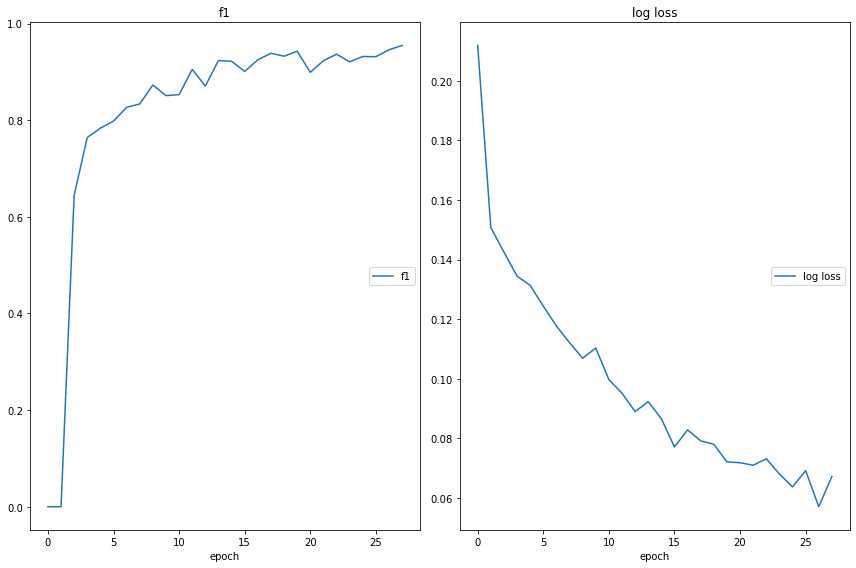

f1
	f1               	 (min:    0.000, max:    0.955, cur:    0.955)
log loss
	log loss         	 (min:    0.057, max:    0.212, cur:    0.067)


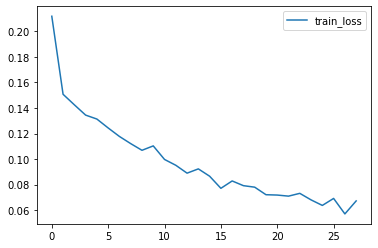

SECRECY-EN_best_model_test_USEm
Best Dev: 27 = 95.48%
loaded test set
Ep best | Eval Test lang en

 | Test: 99.07% | classes: 99.04  0.96

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    691519
           1       0.05      0.74      0.09       451

    accuracy                           0.99    691970
   macro avg       0.53      0.87      0.54    691970
weighted avg       1.00      0.99      0.99    691970



loaded test set
Ep best | Eval Test lang es

 | Test: 96.20% | classes: 96.19  3.81

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     81607
           1       0.02      0.57      0.03        90

    accuracy                           0.96     81697
   macro avg       0.51      0.76      0.51     81697
weighted avg       1.00      0.96      0.98     81697





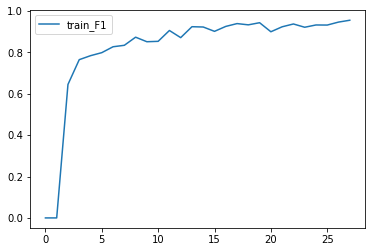

In [11]:
# PURPOSE OF THIS CELL:
# this is the final cell where we train an optimal model. 
# we have now chosen the optimal hyperparameters (lr, wd, epochs)
# we train a nn using the optimal hyperparams on both train+dev combined (more training data than above cell)
# we evaluate on test (in all languages)
# we can use return_df=True to return the test dfs with model scores

# these have already been recorded
#lr_opt = 0.001
#wd_opt = 0.0

args.lr = lr_opt
args.wdecay = wd_opt
#args.nepoch = 70
args.nepoch = epochs_opt

args.final_plot = model_name + "_final_build-test_" + model_name + ".png"
# combines dev and training
def full_train_mlp(args, return_dfs=True, optimize_epochs=False):
        
    liveloss = PlotLosses()

#     train_loader = LoadData(args.base_dir, args.train, args.train_labels,
#                             dim=args.dim, bsize=args.bsize, shuffle=True)

#     train_pos = LoadData_pos(args.base_dir, args.train, args.train_labels,
#                             dim=args.dim, bsize=1, shuffle=True)
    
    train_loader = LoadTrainDevData(args.base_dir, args.train, args.train_labels,
                                    args.dev, args.dev_labels,
                                    dim=args.dim, bsize=args.bsize, shuffle=True)
    
    train_pos = LoadTrainDevData_pos(args.base_dir, args.train, args.train_labels,
                                    args.dev, args.dev_labels,
                                    dim=args.dim, bsize=1, shuffle=True)

    # don't need test set for now
    #test_loader = LoadDataList(args.base_dir, args.test_list_en, args.test_labels+'.en',
                          #dim=args.dim, bsize=args.bsize, shuffle=False)

    #test_text = LoadText(args.base_dir, args.test+'.en', args.test_labels+'.en',
                          #dim=args.dim, bsize=args.bsize, shuffle=False)

    
    # set GPU and random seed
    torch.cuda.set_device(args.gpu)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    print(" - setting seed to %d" % args.seed)

    # create network
    net = Net(idim=args.dim, odim=args.nb_classes,
              nhid=args.nhid, dropout=args.dropout, gpu=args.gpu)
    if args.gpu >= 0:
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        criterion = nn.CrossEntropyLoss()

    #optimizer = optim.Adam(net.parameters(), weight_decay=0.0)
    # default: pytorch/optim/adam.py
    # Py0.4: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    # Py1.0: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    optimizer = optim.AdamW(net.parameters(),
                           lr=args.lr,
                           weight_decay=args.wdecay,
                           betas=(0.9, 0.999),
                           eps=1e-8,
                           amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                                max_lr=args.lr,
    #                                                steps_per_epoch=len(train_loader),
    #                                                epochs=args.nepoch)
    
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_train_f1 = []
    epoch_test_f1 = []
    epoch_id = []
    
    corr_best = 0
    f1_best = 0
    # loop multiple times over the dataset
    for epoch in range(args.nepoch + 1):
        print('Epoch: ' + str(epoch))
        logs = {}

        loss_epoch = 0.0
        print('Ep {:4d}'.format(epoch), end='')
        # for inputs, labels in train_loader:
        for i, data in enumerate(train_loader, 0):
            torch.cuda.empty_cache()
            
            # get the inputs
            inputs, labels = data

            # augment with pos sample
            if data[1][data[1]==1].shape[0] == 0:
                aug_data_pos = iter(train_pos).next()
                inputs = torch.cat([inputs,aug_data_pos[0]])
                labels = torch.cat([labels,aug_data_pos[1]])
            
            labels = labels.long()
            if args.gpu >= 0:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients            
            net.zero_grad()

            # forward + backward + optimize
            net.train(mode=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #for param_group in optimizer.param_groups:
            #    print(param_group['lr'])          
            #scheduler.step()

            loss_epoch += loss.item()
            
        print(' | loss {:e}'.format(loss_epoch), end='')
        print('\n')
        torch.cuda.empty_cache()
        _, _, _, train_clf_reprt = net.TestCorpus_cstm(train_loader, 'Train',nlbl=args.nb_classes)
        torch.cuda.empty_cache()
        del _
        #corr, nbex, test_loss, test_clf_reprt = net.TestCorpus_cstm(test_loader, 'Dev', nlbl=args.nb_classes, txt=test_text)
        #torch.cuda.empty_cache()
        
        # Epoch metrics (train/dev, loss/F1)
        #f1 = test_clf_reprt['1']['f1-score']
        f1 = train_clf_reprt['1']['f1-score']
        
        epoch_id.append(epoch)
        
        epoch_train_loss.append(loss_epoch/float(i))
        #epoch_test_loss.append(test_loss.item())
        
        epoch_train_f1.append(train_clf_reprt['1']['f1-score'])
        #epoch_test_f1.append(test_clf_reprt['1']['f1-score'])
        
        
        # Keeping Record of Best MLP net (based on Dev set)
        #if corr >= corr_best:
        #if f1 >= f1_best:
        #    print(' | saved')
        #    f1_best = f1
        #    epoch_best = epoch
        #    net_best = copy.deepcopy(net)
        #else:
        #    print('')
                    
        ## Plot epochs metrics 
        logs['' + 'log loss'] = loss_epoch/float(i)
        logs['' + 'f1'] = train_clf_reprt['1']['f1-score']
        #logs['val_' + 'log loss'] = test_loss.item()
        #logs['val_' + 'f1'] = test_clf_reprt['1']['f1-score']
        
        liveloss.update(logs)
        liveloss.draw()
        
        torch.cuda.empty_cache()

    plt.plot(epoch_id, epoch_train_loss, label='train_loss')
    #plt.plot(epoch_id, epoch_test_loss, label='dev_loss')
    plt.legend(loc='best')
    plt.show()

    plt.plot(epoch_id, epoch_train_f1, label='train_F1')
    #plt.plot(epoch_id, epoch_test_f1, label='dev_F1')
    plt.legend(loc='best')
    plt.savefig(args.final_plot)
    

    if optimize_epochs==False: # we want to keep the net trained after epochs_opt epochs, not that which maximizes f1 (cheating!)
        f1_best = f1
        epoch_best = epoch
        net_best = copy.deepcopy(net)   
    
    # Saving best MLP net and Producing Zero-Shot Multilingual Results
    if args.save != '':
        torch.save(net_best.cpu(), args.save+'_full')
        print(args.save)
    print('Best Dev: {:d} = {:5.2f}%'.format(epoch_best, 100.0 * f1_best))

    if args.gpu >= 0:
        net_best = net_best.cuda()

    # test on (several) languages
    test_clf_reprt = {}
    
    if return_dfs:
        dfs = {}
        
    
    for l in args.lang:
        # replace args.test + '.' + l,args.test_labels + '.' + l with lists
        if l=='en':
            test_list = args.test_list_en
        if l=='es':
            test_list = args.test_list_es
        test_loader = LoadDataList(args.base_dir, test_list,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)
        print('loaded test set')

        test_txt = LoadText(args.base_dir, args.test + '.' + l,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        print('Ep best | Eval Test lang {:s}'.format(l), end='')
        print('\n')
        _, _, _, test_clf_reprt[l], df = net_best.TestCorpus_cstm(test_loader, 'Test',nlbl=args.nb_classes, txt=test_txt, return_df=True)
        if return_dfs:
            dfs[l] = df
        
        print('\n')
    
    pickle.dump(test_clf_reprt, open( save_model+'_test_metrics_w_full_model.pkl', "wb" ))
    if return_dfs:
        return dfs

dfs = full_train_mlp(args)


In [12]:
def threshold_analysis(labels, model_scores ,thresholds=np.append(np.arange(0.01,0.98,0.01),np.append(np.arange(0.98,0.999,0.001),np.arange(0.999,1.0,0.00001)))):
    #thresholds = np.arange(0.9,1.00,0.001)
    tps = [sum((labels==1) & (model_scores>=x)) for x in thresholds]
    fps = [sum((labels==0) & (model_scores>=x)) for x in thresholds]
    tns = [sum((labels==0) & (model_scores<x)) for x in thresholds]
    fns = [sum((labels==1) & (model_scores<x)) for x in thresholds]
    precision = [None if (tp+fp)==0 else tp/(tp+fp) for tp,fp in zip(tps,fps)]
    recall = [None if (tp+fn)==0 else tp/(tp+fn) for tp,fn in zip(tps,fns)]
    f1 = [None if (p==None) or (r==None) or (p+r==0) else 2*p*r/(p+r) for p,r in zip(precision, recall)]
    prcurve = pd.DataFrame({'Threshold':thresholds,'F1':f1,'Recall':recall,'Precision':precision,
                           'TP':tps,'FP':fps,'TN':tns,'FN':fns})
    prcurve = prcurve[['Threshold','F1','Recall','Precision','TP','FP','TN','FN']]
    prcurve = prcurve.sort_values(by='F1',ascending=False).reset_index(drop=True)
    return prcurve

In [13]:
df = dfs['en']

print(df)

tp = sum((df.labels==1) & (df.predictions==1))
fp = sum((df.labels==0) & (df.predictions==1))
fn = sum((df.labels==1) & (df.predictions==0))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print('Precision: ' + str(round(precision,2)))
print('Recall: ' + str(round(recall,2)))
print('F1: ' + str(round(f1,2)))

# threshold analysis
prcurve = threshold_analysis(df.labels,df.model_scores)
print('Optimal F1 Score: ' + str(round(prcurve.F1[0], 3)))
prcurve.drop_duplicates(subset='TP')[0:20]

                                                     text  labels  \
0                 rob thats good information keep digging       0   
1       i dont think this really applies to anyone on ...       0   
2                                  word on da is not good       0   
3       i do not want to do anything to jeopardize the...       0   
4       instead try to find the pattern and wait for f...       0   
...                                                   ...     ...   
691965  ill put calls into voicemail but im not going ...       1   
691966      all information is kept strictly confidential       1   
691967  from the start ngos opposition parties trade u...       1   
691968  i did not tell him anything about the imbedded...       1   
691969  i think its best to keep it as close to the ve...       1   

        predictions  model_scores  
0                 1      0.911548  
1                 1      0.683055  
2                 0      0.404903  
3                 1      0.

,Threshold,F1,Recall,Precision,TP,FP,TN,FN
0,0.94,0.429058,0.419069,0.439535,189,241,691278,262
1,0.95,0.426702,0.361419,0.520767,163,150,691369,288
2,0.93,0.404834,0.445676,0.370849,201,341,691178,250
3,0.92,0.395853,0.465632,0.344262,210,400,691119,241
4,0.96,0.390462,0.290466,0.595455,131,89,691430,320
5,0.91,0.381034,0.490022,0.311707,221,488,691031,230
6,0.90,0.359300,0.501109,0.280050,226,581,690938,225
7,0.89,0.347633,0.521064,0.260821,235,666,690853,216
8,0.88,0.336100,0.538803,0.244221,243,752,690767,208
9,0.87,0.324675,0.554324,0.229568,250,839,690680,201


In [14]:
df = dfs['es']

print(df)

tp = sum((df.labels==1) & (df.predictions==1))
fp = sum((df.labels==0) & (df.predictions==1))
fn = sum((df.labels==1) & (df.predictions==0))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print('Precision: ' + str(round(precision,2)))
print('Recall: ' + str(round(recall,2)))
print('F1: ' + str(round(f1,2)))

# threshold analysis
prcurve = threshold_analysis(df.labels,df.model_scores)
print('Optimal F1 Score: ' + str(round(prcurve.F1[0], 3)))
prcurve.drop_duplicates(subset='TP')[0:20]

                                                    text  labels  predictions  \
0                           me la vas a pagar en grande        0            0   
1                                pero usted es un pinko        0            0   
2                        no estarían mejor en la cocina        0            0   
3                           me di vuelta por un segundo        0            0   
4                                            estás bien        0            0   
...                                                  ...     ...          ...   
81692                         no lo publicaremos a nadie       1            1   
81693                           nunca hablamos con nadie       1            1   
81694                        trata de no conocer a nadie       1            0   
81695                             son pacíficos porque q       1            0   
81696  es mejor no dar detalles y estás hablando de a...       1            1   

       model_scores  
0    

,Threshold,F1,Recall,Precision,TP,FP,TN,FN
0,0.950,0.144654,0.255556,0.100877,23,205,81402,67
1,0.940,0.129870,0.277778,0.084746,25,270,81337,65
2,0.930,0.125561,0.311111,0.078652,28,328,81279,62
3,0.960,0.125000,0.166667,0.100000,15,135,81472,75
4,0.920,0.114173,0.322222,0.069378,29,389,81218,61
5,0.910,0.111913,0.344444,0.066810,31,433,81174,59
6,0.900,0.103728,0.355556,0.060721,32,495,81112,58
7,0.970,0.101911,0.088889,0.119403,8,59,81548,82
15,0.820,0.061740,0.366667,0.033708,33,946,80661,57
16,0.981,0.060000,0.033333,0.300000,3,7,81600,87
